In [2]:
import numpy as np
import struct
import matplotlib.pyplot as plt

In [6]:
def decode_idx3(dataset_file):
    # read binary data
    bin_data = open(dataset_file, 'rb').read()

    # read headers, the order is: magic number, number of images, height, width
    offset = 0
    fmt_header = '>iiii'
    magic_num, img_num, rows, cols = \
        struct.unpack_from(fmt_header, bin_data, offset)
    print 'magic_num: %d, img_num: %d, image size: %d*%d' % \
          (magic_num, img_num, rows, cols)

    #decode data
    img_size = rows * cols
    offset += struct.calcsize(fmt_header)
    fmt_image = '>' + str(img_size) + 'B'
    images = np.empty((img_num, rows, cols))
    for i in range(img_num):
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset))\
            .reshape((rows, cols))
        offset += struct.calcsize(fmt_image)
        if (i + 1) % 10000 == 0:
            print 'Decoded %d' % (i + 1)
    return images


def decode_idx1(label_file):
    # read binary data
    bin_data = open(label_file, 'rb').read()

    # read headers, the order is: magic number, number of images, height, width
    offset = 0
    fmt_header = '>ii'
    magic_num, img_num = \
        struct.unpack_from(fmt_header, bin_data, offset)
    print 'magic_num: %d, img_num: %d' % (magic_num, img_num)

    #decode data
    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(img_num)
    for i in range(img_num):
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
        if (i + 1) % 10000 == 0:
            print 'Decoded %d' % (i + 1)
    return labels

In [7]:
train_data_file = 'train-images.idx3-ubyte'
train_labels_file = 'train-labels.idx1-ubyte'
test_data_file = 't10k-images.idx3-ubyte'
test_labels_file = 't10k-labels.idx1-ubyte'

train_dataset = decode_idx3(train_data_file)
train_labels = decode_idx1(train_labels_file)
test_dataset = decode_idx3(test_data_file)
test_labels = decode_idx1(test_labels_file)

magic_num: 2051, img_num: 60000, image size: 28*28


Decoded 10000


Decoded 20000


Decoded 30000


Decoded 40000


Decoded 50000


Decoded 60000
magic_num: 2049, img_num: 60000
Decoded 10000
Decoded 20000
Decoded 30000
Decoded 40000
Decoded 50000
Decoded 60000


magic_num: 2051, img_num: 10000, image size: 28*28


Decoded 10000
magic_num: 2049, img_num: 10000
Decoded 10000


In [8]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

# Preprocessing
# randomize both dataset and labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

In [9]:
# Preprocessing
# Turn pixel to binary
train_dataset = (train_dataset[:,:,:] > 127) * 255.0
test_dataset = (test_dataset[:,:,:] > 127) * 255.0

In [10]:
# Preprocessing
num_labels = 10

# reshape labels to [0.0, 1.0, ..., 0.0]
train_labels = np.arange(num_labels) == train_labels[:, None]
test_labels = np.arange(num_labels) == test_labels[:, None]

In [11]:
# Preprocessing
# Zero mean and Normalize
img_range = 255.0;
train_dataset = 1.0 * (train_dataset - img_range / 2) / img_range
test_dataset = 1.0 * (test_dataset - img_range / 2) / img_range

In [12]:
# Preprocessing
# split test dataset to valid and test two parts
valid_dataset = test_dataset[:5000]
valid_labels = test_labels[:5000]
test_dataset = test_dataset[5000:10000]
test_labels = test_labels[5000:10000]

In [15]:
train_dataset = train_dataset.reshape(
    train_dataset.shape[0], image_size, image_size, 1)

(60000, 28, 28, 1)

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator

# Initialization
image_size = 28
truncatedN = keras.initializers.\
    TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0, nesterov=True)

# Initialising the ANN
classifier = Sequential()
classifier.add(Convolution2D(32, (3, 3), input_shape=(image_size, image_size, 1),
                             activation = 'relu', kernel_initializer=truncatedN))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Convolution2D(32, (3, 3),
                             activation = 'relu', kernel_initializer=truncatedN))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Flatten())
classifier.add(Dense(units=128, activation='relu', 
                     kernel_initializer=truncatedN))
classifier.add(Dense(units=10, activation='softmax', 
                     kernel_initializer=truncatedN))

# Compiling the ANN
classifier.compile(optimizer = sgd, loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])


datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train_dataset)

# fits the model on batches with real-time data augmentation:
classifier.fit_generator(datagen.flow(
    train_dataset, train_labels, batch_size=64), 
    steps_per_epoch=len(train_dataset) / 64, epochs=25, verbose=2)

Epoch 1/25


48s - loss: 2.2984 - acc: 0.1473
Epoch 2/25


47s - loss: 2.2656 - acc: 0.2210
Epoch 3/25


49s - loss: 1.9204 - acc: 0.3150
Epoch 4/25


47s - loss: 1.3836 - acc: 0.5267
Epoch 5/25


47s - loss: 0.9575 - acc: 0.6772
Epoch 6/25


48s - loss: 0.7770 - acc: 0.7396
Epoch 7/25


47s - loss: 0.6767 - acc: 0.7729
Epoch 8/25


47s - loss: 0.6063 - acc: 0.7961
Epoch 9/25


47s - loss: 0.5562 - acc: 0.8130
Epoch 10/25


47s - loss: 0.5176 - acc: 0.8262
Epoch 11/25


47s - loss: 0.4856 - acc: 0.8381
Epoch 12/25


47s - loss: 0.4497 - acc: 0.8515
Epoch 13/25


47s - loss: 0.4308 - acc: 0.8578
Epoch 14/25


47s - loss: 0.4119 - acc: 0.8647
Epoch 15/25


51s - loss: 0.3934 - acc: 0.8735
Epoch 16/25


48s - loss: 0.3734 - acc: 0.8785
Epoch 17/25


47s - loss: 0.3577 - acc: 0.8864
Epoch 18/25


47s - loss: 0.3438 - acc: 0.8861
Epoch 19/25


47s - loss: 0.3359 - acc: 0.8911
Epoch 20/25


47s - loss: 0.3231 - acc: 0.8962
Epoch 21/25


47s - loss: 0.3137 - acc: 0.9002
Epoch 22/25


47s - loss: 0.2989 - acc: 0.9052
Epoch 23/25


47s - loss: 0.2960 - acc: 0.9068
Epoch 24/25


47s - loss: 0.2836 - acc: 0.9110
Epoch 25/25


47s - loss: 0.2760 - acc: 0.9114


In [20]:
valid_dataset = valid_dataset.reshape(
    valid_dataset.shape[0], image_size, image_size, 1)
test_dataset = test_dataset.reshape(
    test_dataset.shape[0], image_size, image_size, 1)

# Predicting the Test set results
y_pred_valid = classifier.predict(valid_dataset)
y_pred_test = classifier.predict(test_dataset)

sum = np.sum(np.argmax(y_pred_valid[i]) == np.argmax(valid_labels[i]) 
             for i in range(0, valid_labels.shape[0]))
acc_valid = sum*1.0/5000
sum = np.sum(np.argmax(y_pred_test[i]) == np.argmax(test_labels[i]) 
             for i in range(0, test_labels.shape[0]))
acc_test = sum*1.0/5000

In [36]:
test_data = test_dataset[1000].reshape(1, image_size, image_size, 1)

In [37]:
classifier.predict(test_data)

array([[  3.05748035e-05,   8.61559357e-08,   8.05468517e-06,
          3.93664304e-05,   3.86036164e-03,   4.31162971e-06,
          3.25071755e-06,   2.23221767e-04,   1.58394547e-03,
          9.94246900e-01]], dtype=float32)

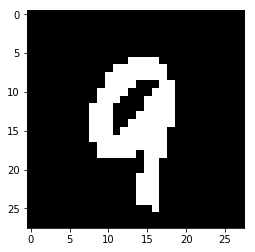

In [40]:
plt.imshow(test_data.reshape(image_size, image_size), cmap='gray')
plt.show()

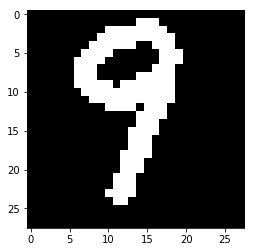

In [47]:
from scipy import misc
num = misc.imread('download.png')
num = num[:,:,0].reshape(image_size, image_size)
plt.imshow(num, cmap='gray')
plt.show()

In [48]:
num = num.reshape(1, image_size, image_size, 1)
num = 1.0 * (num - 127.5) / 255.0
classifier.predict(num)

array([[  1.02290763e-08,   6.46872156e-09,   5.26038320e-07,
          6.02907221e-06,   5.96929422e-05,   2.30388787e-06,
          8.84559004e-09,   9.98119242e-04,   2.98237521e-03,
          9.95950937e-01]], dtype=float32)

In [1]:
# Save a keras model
from keras.models import load_model
classifier.save_weights('model.hdf5')
with open('model.json', 'w') as f:
    f.write(classifier.to_json())

Using TensorFlow backend.


NameError: name 'classifier' is not defined